In [1]:
import dask.dataframe as dd
from yahist import Hist1D
import numpy as np
from dask.distributed import Client
import matplotlib.pyplot as plt

import mplhep
plt.style.use(mplhep.style.CMS)

In [2]:
client = Client(memory_limit='2GB', n_workers=10, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 18.63 GiB
Comm: tcp://127.0.0.1:13394,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 18.63 GiB
Comm: tcp://127.0.0.1:19989,Total threads: 1
Dashboard: http://127.0.0.1:18225/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:12779,


In [4]:
ddf = dd.read_parquet("/hadoop/cms/store/user/hmei/workflowtest/dask_coffea/*parquet")
ddf.head()

,run,event,diphoton_mass,diphoton_ptom,diphoton_eta,diphoton_deltaR,lead_pho_ptom,lead_pho_eta,lead_pho_id,sublead_pho_ptom,...,nMuons,costhetastar_cs,svfit_mass,costheta_gg,costheta_tautau,weight,dataset,vbfjets_eta1_times_eta2,vbfjets_abs_eta_diff,vbfjets_mjj
0,1,531646,125.585999,1.244107,-0.594391,1.416321,1.011410,-0.502563,0.691895,0.583582,...,0,-0.537562,113.901573,-0.464131,-0.296654,5.308373e-07,HH_ggTauTau_2018,-999.0,-999.0,-999.0
1,1,531649,126.220772,1.579348,-0.514050,1.164101,0.883999,-0.023788,0.938477,0.825384,...,0,-0.261008,-1.000000,-0.023784,0.500008,5.308373e-07,HH_ggTauTau_2018,-999.0,-999.0,-999.0
7,1,531664,128.258133,1.007006,-0.158605,1.868156,0.702639,0.523560,0.700684,0.309581,...,0,-0.115039,-1.000000,0.480443,-999.000000,5.308373e-07,HH_ggTauTau_2018,-999.0,-999.0,-999.0
9,1,531669,126.226730,1.674130,-0.761168,1.225444,1.247550,-0.977783,0.728516,0.507644,...,0,-0.339224,-1.000000,-0.752105,-999.000000,5.308373e-07,HH_ggTauTau_2018,-999.0,-999.0,-999.0
10,1,531663,125.198776,1.670002,0.742944,1.539169,1.513730,0.846436,0.932129,0.272269,...,2,0.330430,-1.000000,0.689203,-999.000000,5.308373e-07,HH_ggTauTau_2018,-999.0,-999.0,-999.0


In [5]:
ddf['dataset']=ddf['dataset'].astype(str)
ddf

,run,event,diphoton_mass,diphoton_ptom,diphoton_eta,diphoton_deltaR,lead_pho_ptom,lead_pho_eta,lead_pho_id,sublead_pho_ptom,sublead_pho_eta,sublead_pho_id,nHadTaus,nElectrons,nMuons,costhetastar_cs,svfit_mass,costheta_gg,costheta_tautau,weight,dataset,vbfjets_eta1_times_eta2,vbfjets_abs_eta_diff,vbfjets_mjj
npartitions=470,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
has_2tau = ddf['svfit_mass'] > 0
issignal = ddf['dataset'].str.contains("HH_ggTauTau")
isdiphoton = ddf['dataset'].str.contains("DiPhoton")
isgjets = ddf['dataset'].str.contains("GJet")
iszg = ddf['dataset'].str.contains("ZGamma")
isvh = ddf['dataset'].str.contains("VH")

costheta_signal = ddf[ has_2tau & issignal ]["costhetastar_cs"].compute()
costheta_bkg = ddf[ has_2tau & (isdiphoton | isgjets) & (ddf["weight"] < 2)]["costhetastar_cs"].compute()
costheta_zg = ddf[ has_2tau & iszg ]["costhetastar_cs"].compute()
costheta_vh = ddf[ has_2tau & isvh ]["costhetastar_cs"].compute()

costheta_gg_signal = ddf[ has_2tau & issignal ]["costheta_gg"].compute()
costheta_gg_bkg = ddf[ has_2tau & (isdiphoton | isgjets) & (ddf["weight"] < 2)]["costheta_gg"].compute()
costheta_gg_zg = ddf[ has_2tau & iszg ]["costheta_gg"].compute()
costheta_gg_vh = ddf[ has_2tau & isvh ]["costheta_gg"].compute()

costheta_tautau_signal = ddf[ has_2tau & issignal ]["costheta_tautau"].compute()
costheta_tautau_bkg = ddf[ has_2tau & (isdiphoton | isgjets) & (ddf["weight"] < 2)]["costheta_tautau"].compute()
costheta_tautau_zg = ddf[ has_2tau & iszg ]["costheta_tautau"].compute()
costheta_tautau_vh = ddf[ has_2tau & isvh ]["costheta_tautau"].compute()

weight_signal = ddf[has_2tau & issignal]["weight"].compute()
weight_bkg = ddf[has_2tau & (isdiphoton | isgjets) & (ddf["weight"] < 2)]["weight"].compute()
weight_zg = ddf[has_2tau & iszg]["weight"].compute()
weight_vh = ddf[has_2tau & isvh]["weight"].compute()

In [7]:
h_costhetastar_cs_signal = Hist1D(np.abs(costheta_signal.to_numpy()), weights=weight_signal.to_numpy(), bins=np.linspace(0,1,20))
h_costhetastar_cs_bkg = Hist1D(np.abs(costheta_bkg.to_numpy()), weights=weight_bkg.to_numpy(), bins=np.linspace(0,1,20))
h_costhetastar_cs_vh = Hist1D(np.abs(costheta_vh.to_numpy()), weights=weight_vh.to_numpy(), bins=np.linspace(0,1,20))
h_costhetastar_cs_zg = Hist1D(np.abs(costheta_zg.to_numpy()), weights=weight_zg.to_numpy(), bins=np.linspace(0,1,20))

h_costheta_gg_signal = Hist1D(np.abs(costheta_gg_signal.to_numpy()), weights=weight_signal.to_numpy(), bins=np.linspace(0,1,10))
h_costheta_gg_bkg = Hist1D(np.abs(costheta_gg_bkg.to_numpy()), weights=weight_bkg.to_numpy(), bins=np.linspace(0,1,10))
h_costheta_gg_vh = Hist1D(np.abs(costheta_gg_vh.to_numpy()), weights=weight_vh.to_numpy(), bins=np.linspace(0,1,10))
h_costheta_gg_zg = Hist1D(np.abs(costheta_gg_zg.to_numpy()), weights=weight_zg.to_numpy(), bins=np.linspace(0,1,10))

h_costheta_tautau_signal = Hist1D(np.abs(costheta_tautau_signal.to_numpy()), weights=weight_signal.to_numpy(), bins=np.linspace(0,1,10))
h_costheta_tautau_bkg = Hist1D(np.abs(costheta_tautau_bkg.to_numpy()), weights=weight_bkg.to_numpy(), bins=np.linspace(0,1,10))
h_costheta_tautau_vh = Hist1D(np.abs(costheta_tautau_vh.to_numpy()), weights=weight_vh.to_numpy(), bins=np.linspace(0,1,10))
h_costheta_tautau_zg = Hist1D(np.abs(costheta_tautau_zg.to_numpy()), weights=weight_zg.to_numpy(), bins=np.linspace(0,1,10))

Text(1, 0, '$|cos\\theta*|_{CS}$')

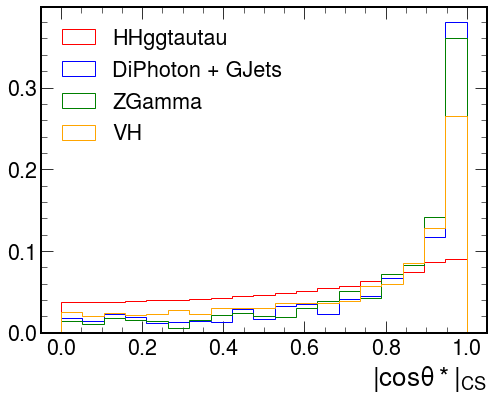

In [8]:
fig, ax = plt.subplots(1, figsize=(8,6) )
h_costhetastar_cs_signal.normalize().plot(ax=ax, color="red", label="HHggtautau")
h_costhetastar_cs_bkg.normalize().plot(ax=ax, color="blue", label="DiPhoton + GJets")
h_costhetastar_cs_zg.normalize().plot(ax=ax, color="green", label="ZGamma")
h_costhetastar_cs_vh.normalize().plot(ax=ax, color="orange", label="VH")
plt.legend(loc='upper left')
ax.set_xlabel(r'$|cos\theta*|_{CS}$')

Text(1, 0, '$|cos(\\theta_{gg})|$')

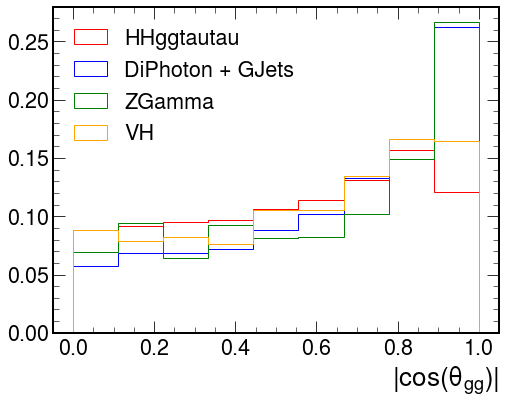

In [9]:
fig, ax = plt.subplots(1, figsize=(8,6) )
h_costheta_gg_signal.normalize().plot(ax=ax, color="red", label="HHggtautau")
h_costheta_gg_bkg.normalize().plot(ax=ax, color="blue", label="DiPhoton + GJets")
h_costheta_gg_zg.normalize().plot(ax=ax, color="green", label="ZGamma")
h_costheta_gg_vh.normalize().plot(ax=ax, color="orange", label="VH")
plt.legend(loc='upper left')
ax.set_xlabel(r'$|cos(\theta_{gg})|$')

Text(1, 0, '$|cos(\\theta_{tautau})|$')

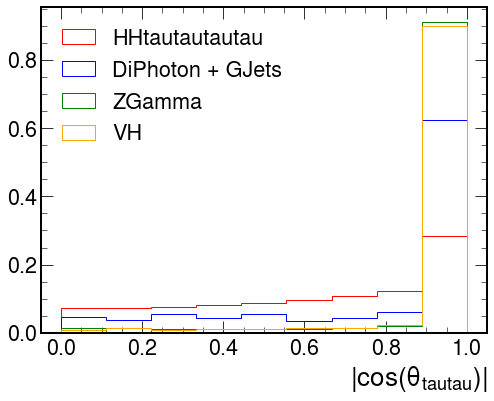

In [10]:
fig, ax = plt.subplots(1, figsize=(8,6) )
h_costheta_tautau_signal.normalize().plot(ax=ax, color="red", label="HHtautautautau")
h_costheta_tautau_bkg.normalize().plot(ax=ax, color="blue", label="DiPhoton + GJets")
h_costheta_tautau_zg.normalize().plot(ax=ax, color="green", label="ZGamma")
h_costheta_tautau_vh.normalize().plot(ax=ax, color="orange", label="VH")
plt.legend(loc='upper left')
ax.set_xlabel(r'$|cos(\theta_{tautau})|$')

In [11]:
client.close()